In [ ]:
"""
Copyright (c) 2025, Majed Kikhia
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

Author: Majed Kikhia
February 2025

Input: the spreadsheets output of the code "morphology_analysis_after_unet.ijm"

What does this code do? 
It create violin and UMAP plots based on the morphological data. 

Output: Fig. 5b, plots of Fig. 5c, and supplementary Fig. 7c
    
"""

# Importing libraries and setting some setups
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import umap

import pingouin as pg
import scikit_posthocs as sp

pd.options.display.float_format = "{:.6f}".format
plt.rcParams["svg.fonttype"] ="none"

# Auto reloads notebook when changes are made
%reload_ext autoreload
%autoreload 2

In [2]:
# Setting parameters for analysis

"""
Out of the following parameters

"Volume", "SurfaceArea", "MeanBreadth", "Sphericity", "EulerNumber", "Elli.R1", "Elli.R2",  "Elli.R3",
"Elli.Azim", "Elli.Elev", "Elli.Roll", "Elli.R1/R2", "Elli.R1/R3", "Elli.R2/R3","InscrBall.Radius",
"# Branches", "# Junctions", "# End-point voxels", "# Junction voxels", "# Slab voxels",
"Average Branch Length", "# Triple points", "# Quadruple points", "Maximum Branch Length",
"Longest Shortest Path", "Surface/Vol", "ram_idx", "skeleton_length"
"""

# Parameters to include (The minimal number of meaningful parameters)
minimal_parameters = ["Surface/Vol", "Sphericity", "Elli.R3", "Longest Shortest Path", "skeleton_length"]

# Scaling method for scaling the data
scaling_method = "MinMaxScaler" #Select "standard" OR "robust" OR "MaxAbsScaler" OR "MinMaxScaler" OR "matched_scale"

# Hyperparamters of the UMAP analysis  
n_neighbors = 100
min_dist = 0.01
metric = "euclidean"

In [3]:
# Reading all csv tables and saving them to one dataframe

path =  r"C:/Users/majed/Desktop/My Directory/Work/Git/20230321_Unet Excel sheets" # Insert the directory where the output datasheets for the morphology analysis in ImageJ are saved

files = glob.glob(path + "/*.csv")

df_Microglia = pd.concat([pd.read_csv(fp).assign(Filename=os.path.basename(fp)) for fp in files])

df_Microglia = df_Microglia.reset_index(drop=True)
df_Microglia

,Label,VoxelCount,Volume,SurfaceArea,MeanBreadth,Sphericity,EulerNumber,Box.X.Min,Box.X.Max,Box.Y.Min,...,# Slab voxels,Average Branch Length,# Triple points,# Quadruple points,Maximum Branch Length,Longest Shortest Path,spx,spy,spz,Filename
0,1.000000,92164.000000,2251.320000,3324.325000,123.305000,0.016000,-19.000000,46.106000,106.591000,65.955000,...,1268,4.297000,28,1,18.516000,97.615000,60.173000,55.328000,0,20220906_L6_KGE-4590_2d_contra_1.czi_Results.csv
1,1.000000,123463.000000,3015.871000,5261.778000,231.422000,0.007000,-24.000000,21.256000,86.117000,41.574000,...,2259,2.743000,82,7,19.695000,97.215000,37.041000,55.015000,0,20220906_L6_KGE-4590_2d_contra_2.czi_Results.csv
2,1.000000,155297.000000,3793.490000,7272.785000,328.605000,0.004000,-72.000000,42.980000,94.870000,55.640000,...,2834,2.356000,129,14,14.209000,94.790000,51.420000,13.441000,0,20220906_L6_KGE-4590_2d_contra_3.czi_Results.csv
3,1.000000,153016.000000,3737.771000,6146.986000,238.570000,0.007000,-46.000000,55.171000,96.589000,47.044000,...,2317,3.021000,79,7,17.745000,94.269000,40.636000,5.470000,0,20220906_L6_KGE-4590_2d_contra_4.czi_Results.csv
4,1.000000,112089.000000,2738.034000,5342.861000,281.261000,0.006000,-148.000000,89.243000,150.822000,77.052000,...,2074,1.973000,118,13,7.999000,84.643000,58.610000,7.971000,0,20220906_L6_KGE-4590_2d_contra_5.czi_Results.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.000000,79151.000000,1933.447000,2042.862000,80.097000,0.050000,-4.000000,105.341000,139.725000,32.196000,...,946,4.105000,22,2,11.972000,56.474000,31.258000,13.129000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
670,6.000000,68553.000000,1674.566000,1481.864000,47.189000,0.097000,0.000000,18.755000,41.261000,114.250000,...,562,3.944000,15,0,17.346000,33.490000,20.162000,23.131000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
671,7.000000,25086.000000,612.784000,689.542000,26.418000,0.130000,1.000000,130.192000,148.947000,112.374000,...,221,4.821000,4,0,7.703000,25.738000,18.130000,5.314000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
672,8.000000,58550.000000,1430.220000,1572.520000,59.964000,0.059000,-3.000000,35.478000,60.798000,6.564000,...,682,4.287000,15,1,11.271000,62.585000,19.849000,53.765000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv


In [4]:
# Renaming some columsn and adding empty columns to hold metadata from file name

df_Microglia.rename(columns={"Label": "CellIDinImage"})

df_Microglia.insert(1, "Date", "")
df_Microglia.insert(2, "ImageOrder", "")
df_Microglia.insert(4, "Experiment", "")
df_Microglia.insert(5, "Animal", "")
df_Microglia.insert(6, "Timepoint", "")
df_Microglia.insert(7, "Stroke", "")
df_Microglia.insert(8, "Grouping", "")
   
df_Microglia

,Label,Date,ImageOrder,VoxelCount,Experiment,Animal,Timepoint,Stroke,Grouping,Volume,...,# Slab voxels,Average Branch Length,# Triple points,# Quadruple points,Maximum Branch Length,Longest Shortest Path,spx,spy,spz,Filename
0,1.000000,,,92164.000000,,,,,,2251.320000,...,1268,4.297000,28,1,18.516000,97.615000,60.173000,55.328000,0,20220906_L6_KGE-4590_2d_contra_1.czi_Results.csv
1,1.000000,,,123463.000000,,,,,,3015.871000,...,2259,2.743000,82,7,19.695000,97.215000,37.041000,55.015000,0,20220906_L6_KGE-4590_2d_contra_2.czi_Results.csv
2,1.000000,,,155297.000000,,,,,,3793.490000,...,2834,2.356000,129,14,14.209000,94.790000,51.420000,13.441000,0,20220906_L6_KGE-4590_2d_contra_3.czi_Results.csv
3,1.000000,,,153016.000000,,,,,,3737.771000,...,2317,3.021000,79,7,17.745000,94.269000,40.636000,5.470000,0,20220906_L6_KGE-4590_2d_contra_4.czi_Results.csv
4,1.000000,,,112089.000000,,,,,,2738.034000,...,2074,1.973000,118,13,7.999000,84.643000,58.610000,7.971000,0,20220906_L6_KGE-4590_2d_contra_5.czi_Results.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.000000,,,79151.000000,,,,,,1933.447000,...,946,4.105000,22,2,11.972000,56.474000,31.258000,13.129000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
670,6.000000,,,68553.000000,,,,,,1674.566000,...,562,3.944000,15,0,17.346000,33.490000,20.162000,23.131000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
671,7.000000,,,25086.000000,,,,,,612.784000,...,221,4.821000,4,0,7.703000,25.738000,18.130000,5.314000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
672,8.000000,,,58550.000000,,,,,,1430.220000,...,682,4.287000,15,1,11.271000,62.585000,19.849000,53.765000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv


In [5]:
# Extracting the metadata from filename and saving it in the corresponding columns 

def decode_Date(filename):
        return filename[0:8]

def decode_ImageOrder(filename):
    if filename[24:30] == "contra": 
        return filename[31]
    else:
        return filename[29]

def decode_Stroke(filename):
    if filename[24:30] == "contra":
        return "Contralateral"
    else: 
        return "Stroke"
    
def decode_Experiment(filename):
        return filename[9:11]
    
def decode_Animal(filename):
        return filename[12:20]

def decode_Timepoint(filename):
    return filename[21:23]

def decode_Grouping(filename):   # this is bascially to group all contralateral cells from all timepoints in one group 
    if filename[24:30] == "contra":
        return "Contralateral"
    else:
        return filename[21:23]

df_Microglia["Date"] = df_Microglia["Filename"].apply(
    decode_Date
)

df_Microglia["ImageOrder"] = df_Microglia["Filename"].apply(
    decode_ImageOrder
)


df_Microglia["Stroke"] = df_Microglia["Filename"].apply(
    decode_Stroke
)

df_Microglia["Experiment"] = df_Microglia["Filename"].apply(
    decode_Experiment
)

df_Microglia["Animal"] = df_Microglia["Filename"].apply(
    decode_Animal
)

df_Microglia["Timepoint"] = df_Microglia["Filename"].apply(
    decode_Timepoint
)

df_Microglia["Grouping"] = df_Microglia["Filename"].apply(
    decode_Grouping
)

        
df_Microglia

,Label,Date,ImageOrder,VoxelCount,Experiment,Animal,Timepoint,Stroke,Grouping,Volume,...,# Slab voxels,Average Branch Length,# Triple points,# Quadruple points,Maximum Branch Length,Longest Shortest Path,spx,spy,spz,Filename
0,1.000000,20220906,1,92164.000000,L6,KGE-4590,2d,Contralateral,Contralateral,2251.320000,...,1268,4.297000,28,1,18.516000,97.615000,60.173000,55.328000,0,20220906_L6_KGE-4590_2d_contra_1.czi_Results.csv
1,1.000000,20220906,2,123463.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3015.871000,...,2259,2.743000,82,7,19.695000,97.215000,37.041000,55.015000,0,20220906_L6_KGE-4590_2d_contra_2.czi_Results.csv
2,1.000000,20220906,3,155297.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3793.490000,...,2834,2.356000,129,14,14.209000,94.790000,51.420000,13.441000,0,20220906_L6_KGE-4590_2d_contra_3.czi_Results.csv
3,1.000000,20220906,4,153016.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3737.771000,...,2317,3.021000,79,7,17.745000,94.269000,40.636000,5.470000,0,20220906_L6_KGE-4590_2d_contra_4.czi_Results.csv
4,1.000000,20220906,5,112089.000000,L6,KGE-4590,2d,Contralateral,Contralateral,2738.034000,...,2074,1.973000,118,13,7.999000,84.643000,58.610000,7.971000,0,20220906_L6_KGE-4590_2d_contra_5.czi_Results.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.000000,20220919,5,79151.000000,L9,KGE-5313,1w,Stroke,1w,1933.447000,...,946,4.105000,22,2,11.972000,56.474000,31.258000,13.129000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
670,6.000000,20220919,5,68553.000000,L9,KGE-5313,1w,Stroke,1w,1674.566000,...,562,3.944000,15,0,17.346000,33.490000,20.162000,23.131000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
671,7.000000,20220919,5,25086.000000,L9,KGE-5313,1w,Stroke,1w,612.784000,...,221,4.821000,4,0,7.703000,25.738000,18.130000,5.314000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv
672,8.000000,20220919,5,58550.000000,L9,KGE-5313,1w,Stroke,1w,1430.220000,...,682,4.287000,15,1,11.271000,62.585000,19.849000,53.765000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv


In [6]:
# Excluding any images with no segmented cells

df_Microglia = df_Microglia[df_Microglia["# Slab voxels"] != 0]
df_Microglia.shape

(668, 53)

In [7]:
# Calculating extra paramters

pixel_size = 0.1562924

df_Microglia = df_Microglia.copy()

df_Microglia.loc[:, "Surface/Vol"] = df_Microglia["SurfaceArea"] / df_Microglia["Volume"]

df_Microglia.loc[:, "skeleton_length"] = (df_Microglia["# End-point voxels"] + df_Microglia["# Slab voxels"] + df_Microglia["# Junction voxels"])*pixel_size

df_Microglia

,Label,Date,ImageOrder,VoxelCount,Experiment,Animal,Timepoint,Stroke,Grouping,Volume,...,# Triple points,# Quadruple points,Maximum Branch Length,Longest Shortest Path,spx,spy,spz,Filename,Surface/Vol,skeleton_length
0,1.000000,20220906,1,92164.000000,L6,KGE-4590,2d,Contralateral,Contralateral,2251.320000,...,28,1,18.516000,97.615000,60.173000,55.328000,0,20220906_L6_KGE-4590_2d_contra_1.czi_Results.csv,1.476611,209.744401
1,1.000000,20220906,2,123463.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3015.871000,...,82,7,19.695000,97.215000,37.041000,55.015000,0,20220906_L6_KGE-4590_2d_contra_2.czi_Results.csv,1.744696,390.262123
2,1.000000,20220906,3,155297.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3793.490000,...,129,14,14.209000,94.790000,51.420000,13.441000,0,20220906_L6_KGE-4590_2d_contra_3.czi_Results.csv,1.917175,496.228370
3,1.000000,20220906,4,153016.000000,L6,KGE-4590,2d,Contralateral,Contralateral,3737.771000,...,79,7,17.745000,94.269000,40.636000,5.470000,0,20220906_L6_KGE-4590_2d_contra_4.czi_Results.csv,1.644559,396.044942
4,1.000000,20220906,5,112089.000000,L6,KGE-4590,2d,Contralateral,Contralateral,2738.034000,...,118,13,7.999000,84.643000,58.610000,7.971000,0,20220906_L6_KGE-4590_2d_contra_5.czi_Results.csv,1.951349,373.226251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.000000,20220919,5,79151.000000,L9,KGE-5313,1w,Stroke,1w,1933.447000,...,22,2,11.972000,56.474000,31.258000,13.129000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv,1.056591,158.636786
670,6.000000,20220919,5,68553.000000,L9,KGE-5313,1w,Stroke,1w,1674.566000,...,15,0,17.346000,33.490000,20.162000,23.131000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv,0.884924,94.400610
671,7.000000,20220919,5,25086.000000,L9,KGE-5313,1w,Stroke,1w,612.784000,...,4,0,7.703000,25.738000,18.130000,5.314000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv,1.125261,36.103544
672,8.000000,20220919,5,58550.000000,L9,KGE-5313,1w,Stroke,1w,1430.220000,...,15,1,11.271000,62.585000,19.849000,53.765000,0,20220919_L9_KGE-5313_1w_ipsi_5.czi_Results.csv,1.099495,113.468282


In [8]:
# Selecting meaningful morphological parameters

df_selected = df_Microglia[["Volume", "SurfaceArea", "MeanBreadth", "Sphericity", "EulerNumber", "Elli.R1", "Elli.R2",  "Elli.R3",
                       "Elli.Azim", "Elli.Elev", "Elli.Roll", "Elli.R1/R2", "Elli.R1/R3", "Elli.R2/R3","InscrBall.Radius",
                       "# Branches", "# Junctions", "# End-point voxels", "# Junction voxels", "# Slab voxels",
                       "Average Branch Length", "# Triple points", "# Quadruple points", "Maximum Branch Length",
                       "Longest Shortest Path", "Surface/Vol", "skeleton_length"]].copy()


df_selected

,Volume,SurfaceArea,MeanBreadth,Sphericity,EulerNumber,Elli.R1,Elli.R2,Elli.R3,Elli.Azim,Elli.Elev,...,# End-point voxels,# Junction voxels,# Slab voxels,Average Branch Length,# Triple points,# Quadruple points,Maximum Branch Length,Longest Shortest Path,Surface/Vol,skeleton_length
0,2251.320000,3324.325000,123.305000,0.016000,-19.000000,38.499000,15.496000,8.198000,53.056000,-7.628000,...,26,48,1268,4.297000,28,1,18.516000,97.615000,1.476611,209.744401
1,3015.871000,5261.778000,231.422000,0.007000,-24.000000,28.277000,21.952000,9.656000,41.920000,11.779000,...,61,177,2259,2.743000,82,7,19.695000,97.215000,1.744696,390.262123
2,3793.490000,7272.785000,328.605000,0.004000,-72.000000,24.186000,21.305000,12.736000,30.750000,-10.323000,...,60,281,2834,2.356000,129,14,14.209000,94.790000,1.917175,496.228370
3,3737.771000,6146.986000,238.570000,0.007000,-46.000000,32.829000,17.859000,9.224000,-87.175000,7.543000,...,46,171,2317,3.021000,79,7,17.745000,94.269000,1.644559,396.044942
4,2738.034000,5342.861000,281.261000,0.006000,-148.000000,32.049000,10.197000,9.907000,-26.729000,2.980000,...,57,257,2074,1.973000,118,13,7.999000,84.643000,1.951349,373.226251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,1933.447000,2042.862000,80.097000,0.050000,-4.000000,15.353000,13.037000,7.172000,11.916000,10.796000,...,20,49,946,4.105000,22,2,11.972000,56.474000,1.056591,158.636786
670,1674.566000,1481.864000,47.189000,0.097000,0.000000,11.500000,8.347000,7.221000,43.806000,9.901000,...,13,29,562,3.944000,15,0,17.346000,33.490000,0.884924,94.400610
671,612.784000,689.542000,26.418000,0.130000,1.000000,11.154000,5.273000,4.367000,-55.070000,-6.638000,...,6,4,221,4.821000,4,0,7.703000,25.738000,1.125261,36.103544
672,1430.220000,1572.520000,59.964000,0.059000,-3.000000,30.275000,7.485000,4.645000,73.803000,-0.996000,...,13,31,682,4.287000,15,1,11.271000,62.585000,1.099495,113.468282


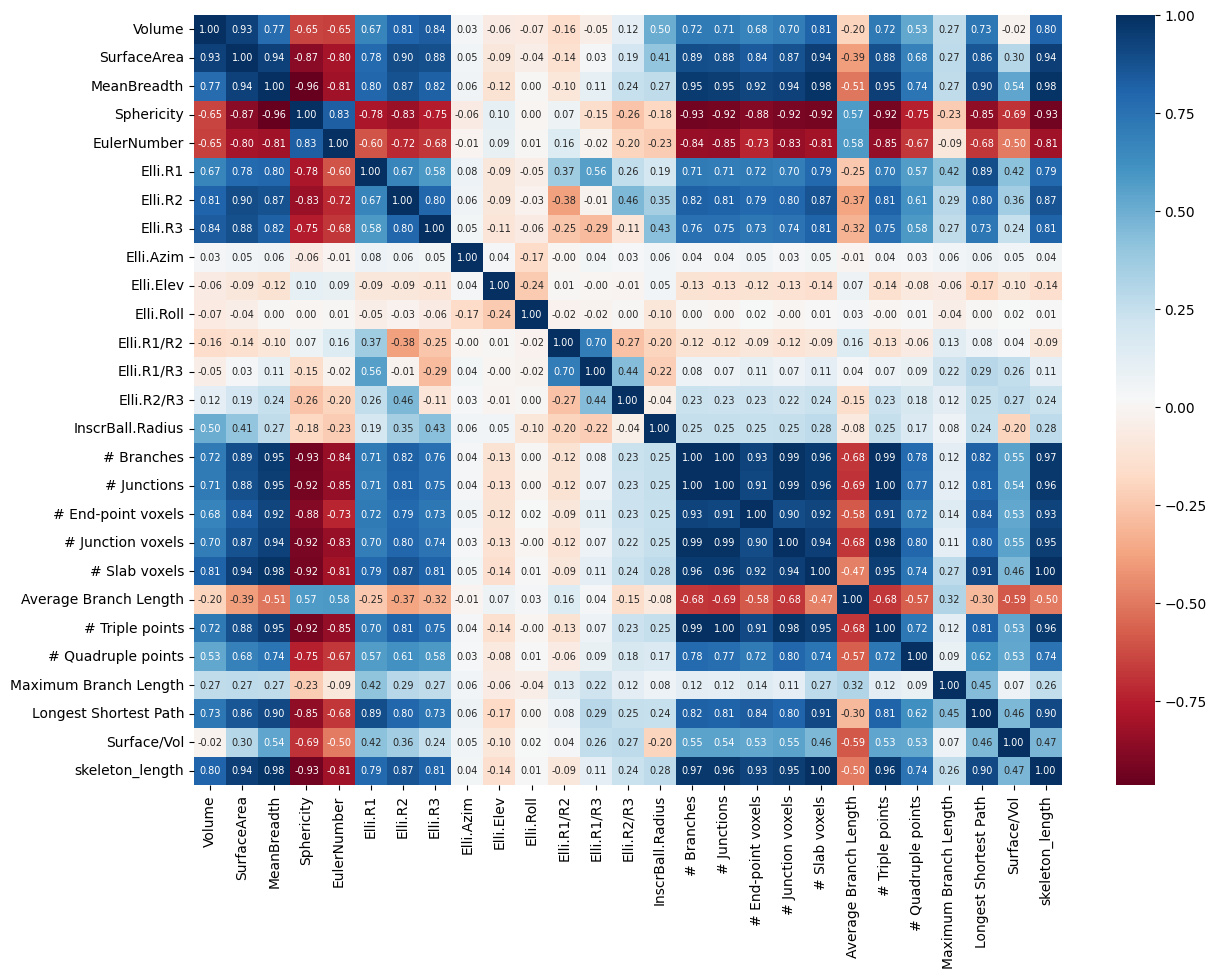

In [9]:
# Creating a heatmap to explore the correlation between parameters

corr_matrix = df_selected.corr(method="spearman")

plt.figure(figsize=(14, 10))  

dataplot = sns.heatmap(
    corr_matrix, 
    cmap="RdBu", 
    annot=corr_matrix.values,  
    fmt=".2f",  
    annot_kws={"size": 7}  
)

# plt.savefig("Spearman correlation heatmap.svg")

In [10]:
# Creating a data frame with a minimum selection of parameters

df_minimal = df_selected[minimal_parameters].copy()
df_minimal

,Surface/Vol,Sphericity,Elli.R3,Longest Shortest Path,skeleton_length
0,1.476611,0.016000,8.198000,97.615000,209.744401
1,1.744696,0.007000,9.656000,97.215000,390.262123
2,1.917175,0.004000,12.736000,94.790000,496.228370
3,1.644559,0.007000,9.224000,94.269000,396.044942
4,1.951349,0.006000,9.907000,84.643000,373.226251
...,...,...,...,...,...
669,1.056591,0.050000,7.172000,56.474000,158.636786
670,0.884924,0.097000,7.221000,33.490000,94.400610
671,1.125261,0.130000,4.367000,25.738000,36.103544
672,1.099495,0.059000,4.645000,62.585000,113.468282


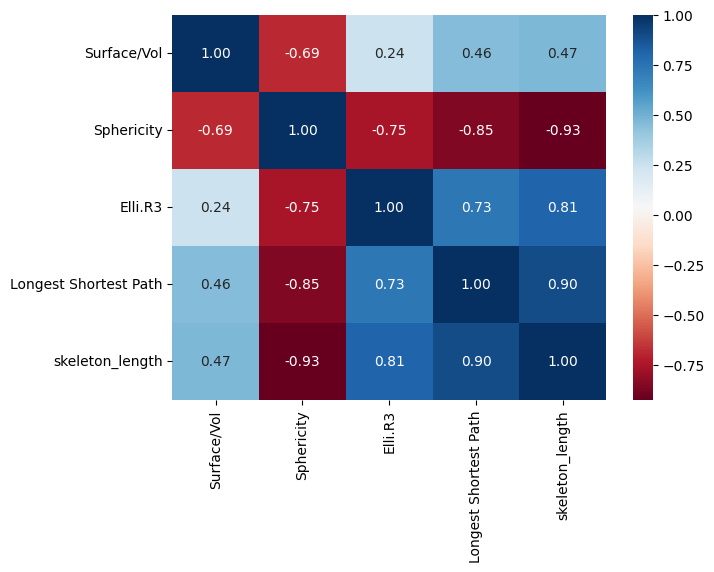

In [11]:
# Create a correlation heatmap for the minumum selection of parameters

corr_matrix = df_minimal.corr(method="spearman")

plt.figure(figsize=(7, 5))  

dataplot = sns.heatmap(
    corr_matrix, 
    cmap="RdBu", 
    annot=corr_matrix.values,  
    fmt=".2f",  
    annot_kws={"size": 10}  
)

# plt.savefig("Correlation_Heatmap.svg")

In [12]:
# Adding grouping variable to the data frames
df_selected.insert(len(df_selected.columns), "Grouping", "")    
df_selected.loc[:, "Grouping"] = df_Microglia.loc[:, "Grouping"]

df_minimal.insert(len(df_minimal.columns), "Grouping", "")    
df_minimal.loc[:, "Grouping"] = df_Microglia.loc[:, "Grouping"]


In [13]:
# Scaling the dataset
# As we can see, most of the variables have many outliers. So we will use robust scaling to minimize the effect of outliers

from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler, MinMaxScaler

def scale_data(df, scaling_method):
    grouping_var = df["Grouping"].copy()  # Ensure independent copy
    dropping_keywords = ("Grouping", "UMAP")  # Columns to exclude
    df = df.drop(columns=[col for col in df.columns if any(k in col for k in dropping_keywords)])

    if scaling_method == "standard":
        scaler = StandardScaler()
    elif scaling_method == "robust":
        scaler = RobustScaler()
    elif scaling_method == "MaxAbsScaler":
        scaler = MaxAbsScaler()
    elif scaling_method == "MinMaxScaler":
        scaler = MinMaxScaler()
    
    scaled_data = scaler.fit_transform(df)
    print("The shape of the scaled data is: " + str(scaled_data.shape))

    df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

    df_scaled["Grouping"] = grouping_var.values  # Use .values to prevent index misalignment

    return df_scaled


df_minimal_scaled = scale_data(df_minimal, scaling_method)

df_minimal_scaled

The shape of the scaled data is: (668, 5)


,Surface/Vol,Sphericity,Elli.R3,Longest Shortest Path,skeleton_length,Grouping
0,0.599568,0.023529,0.501730,0.684108,0.234541,Contralateral
1,0.780825,0.008403,0.621849,0.681068,0.442762,Contralateral
2,0.897441,0.003361,0.875597,0.662636,0.564990,Contralateral
3,0.713121,0.008403,0.586258,0.658676,0.449432,Contralateral
4,0.920547,0.006723,0.642528,0.585510,0.423112,Contralateral
...,...,...,...,...,...,...
669,0.315585,0.080672,0.417202,0.371401,0.175590,1w
670,0.199519,0.159664,0.421239,0.196703,0.101496,1w
671,0.362014,0.215126,0.186110,0.137781,0.034253,1w
672,0.344594,0.095798,0.209013,0.417850,0.123490,1w


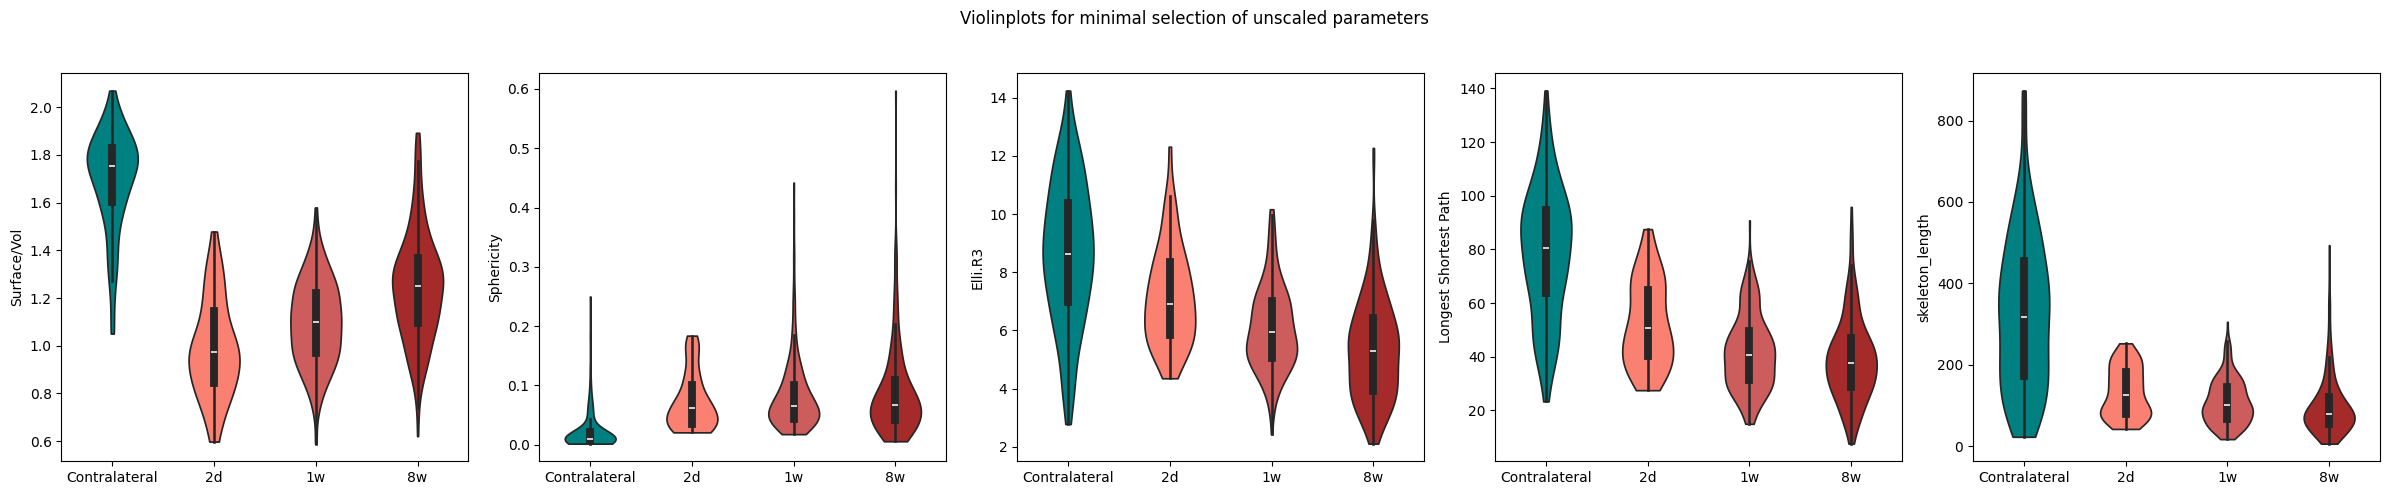

In [14]:
# Plotting the selected variables as violin plots before scaling

# color palette as dictionary
my_palette = {"Contralateral":"teal",
              "2d":"salmon",
              "1w":"indianred",
              "8w":"brown"}

def mulit_violinplots(df, title):

    fig = plt.figure(figsize=(24, 5))
    fig.suptitle(title)
    
    for i, variable in enumerate(df.columns[:-1]):
        plt.subplot(1,5,i+1)
        g = sns.violinplot(y=variable, x="Grouping",
                           order=["Contralateral", "2d", "1w", "8w"], data=df, hue="Grouping", 
                           palette= my_palette, saturation=1, cut=0, width=0.5, legend=False)
        g.set(xlabel=None)
        g.figure.subplots_adjust(wspace=1, hspace=0.2, top=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(title + ".svg")
    plt.show()

title = "Violinplots for minimal selection of unscaled parameters"
mulit_violinplots(df_minimal, title)

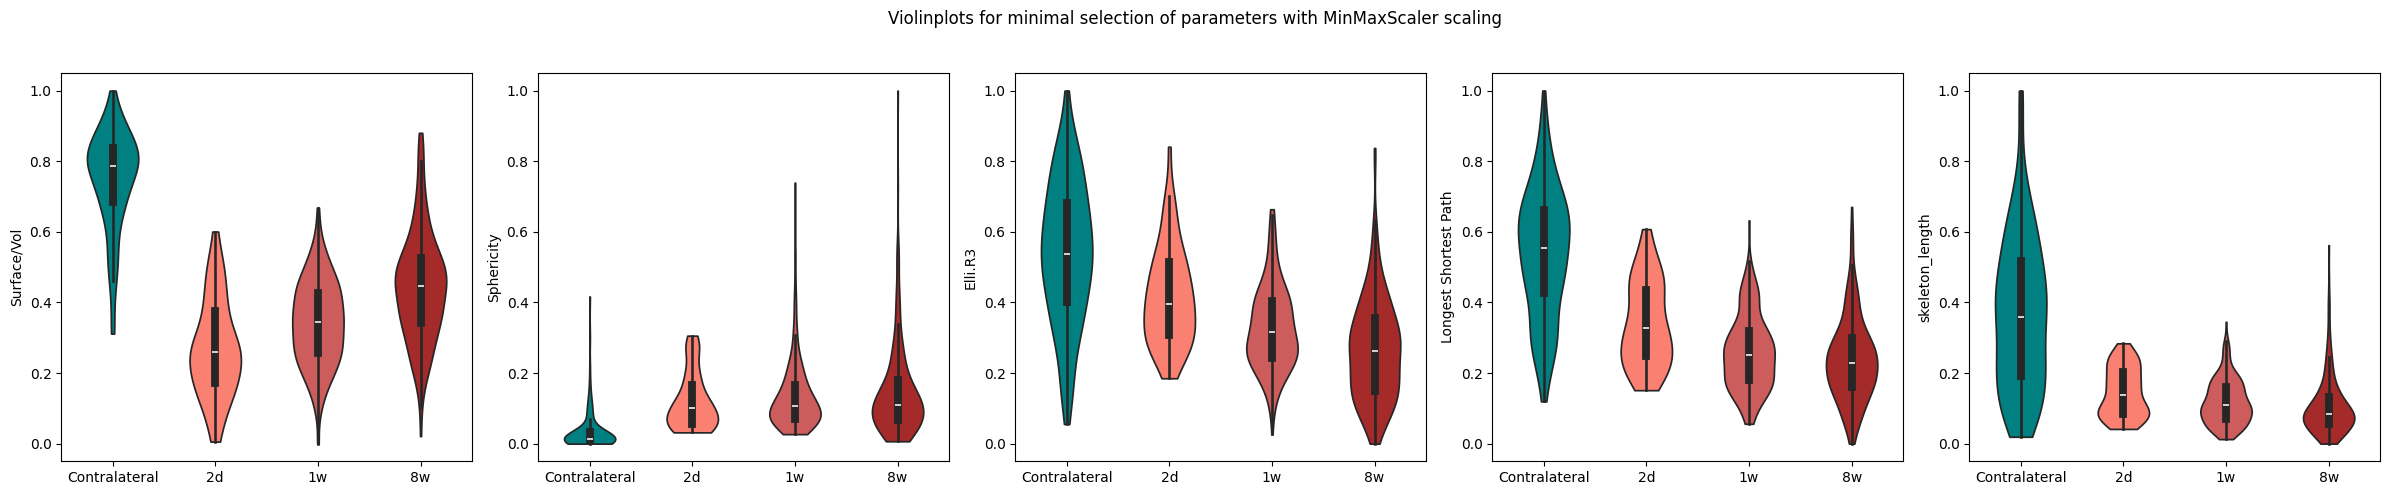

In [15]:
# Plotting the same variables after scaling
title = f"Violinplots for minimal selection of parameters with {scaling_method} scaling"
mulit_violinplots(df_minimal_scaled, title)

In [ ]:
# Functions for running UMAP analysis and plotting the results

def run_UMAP(df, n_neighbors, min_dist, metric):

    grouping_var = df["Grouping"]
    dropping_keywords = ("Grouping", "UMAP")
    df = df.drop(columns=[col for col in df.columns if any(k in col for k in dropping_keywords)])

    umap_model = umap.UMAP(
    n_neighbors=n_neighbors,  # Controls local vs. global structure
    min_dist=min_dist,    # Controls clustering tightness
    n_components=2,  # 2D visualization
    metric=metric,  # Distance metric (try "manhattan" or "canberra")
    random_state=42
    )
    
    umap_results = umap_model.fit_transform(df)

    df.insert(len(df.columns), f"UMAP1_nn{n_neighbors}_md{min_dist}_{metric}", "")
    df.loc[:, f"UMAP1_nn{n_neighbors}_md{min_dist}_{metric}"] = umap_results[:,0]

    df.insert(len(df.columns), f"UMAP2_nn{n_neighbors}_md{min_dist}_{metric}", "")
    df.loc[:, f"UMAP2_nn{n_neighbors}_md{min_dist}_{metric}"] = umap_results[:,1]

    df.insert(len(df.columns), "Grouping", "")
    df["Grouping"] = grouping_var

    return(df)



def general_plot(df, title):
    fig = plt.figure(layout="constrained", figsize=(4, 4))
    fig.suptitle(title)

    x_var = [col for col in df.columns if any(k in col for k in ("UMAP1"))][0]
    y_var = [col for col in df.columns if any(k in col for k in ("UMAP2"))][0]

    sns.scatterplot(x=x_var, y=y_var, data=df, s=30, c = "silver", linewidth = 0)
    # plt.savefig(title + ".svg")
    plt.show()



def scatterplot_time(df, title):
    fig, axes = plt.subplots(1,4, figsize=(20, 4), sharey=True)
    fig.suptitle(title)
    plt.subplots_adjust(top=0.8) 
    
    x_var = [col for col in df.columns if any(k in col for k in ("UMAP1"))][0]
    y_var = [col for col in df.columns if any(k in col for k in ("UMAP2"))][0]

    sns.scatterplot(ax = axes[0], x=x_var, y=y_var, data=df[df["Grouping"] != "Contralateral"], color="silver", s=30, linewidth = 0)
    sns.scatterplot(ax = axes[0], x=x_var, y=y_var, data=df[df["Grouping"] == "Contralateral"], color="teal", s=30, linewidth = 0)
    axes[0].set_title("Contralateral")
    axes[0].set(yticks=[])
    axes[0].set(xticks=[])
    axes[0].set(xlabel=None)
    axes[0].set(ylabel=None)

    sns.scatterplot(ax = axes[1], x=x_var, y=y_var, data=df[df["Grouping"] != "2d"], color="silver", s=30, linewidth = 0)
    sns.scatterplot(ax = axes[1], x=x_var, y=y_var, data=df[df["Grouping"] == "2d"], color="salmon", s=30, linewidth = 0)
    axes[1].set_title("2d")
    axes[1].set(xticks=[])
    axes[1].set(xlabel=None)
    axes[1].set(ylabel=None)

    sns.scatterplot(ax = axes[2], x=x_var, y=y_var, data=df[df["Grouping"] != "1w"], color="silver", s=30, linewidth = 0)
    sns.scatterplot(ax = axes[2], x=x_var, y=y_var, data=df[df["Grouping"] == "1w"], color="indianred", s=30, linewidth = 0)
    axes[2].set_title("1w")
    axes[2].set(xticks=[])
    axes[2].set(xlabel=None)
    axes[2].set(ylabel=None)

    sns.scatterplot(ax = axes[3], x=x_var, y=y_var, data=df[df["Grouping"] != "8w"], color="silver", s=30, linewidth = 0)
    sns.scatterplot(ax = axes[3], x=x_var, y=y_var, data=df[df["Grouping"] == "8w"], color="brown", s=30, linewidth = 0)
    axes[3].set_title("8w")
    axes[3].set(xticks=[])
    axes[3].set(xlabel=None)
    axes[3].set(ylabel=None)
    # plt.savefig(title + ".svg")
    plt.show()


def scatterplot_heat(df, title):
    fig, axes = plt.subplots(1, 10, figsize=(25, 4), 
                             gridspec_kw={"width_ratios": [10, 0.5, 10, 0.5, 10, 0.5, 10, 0.5, 10, 0.5]})
    fig.tight_layout(pad=2)
    
    fig.suptitle(title)
    plt.subplots_adjust(top=0.8) 

    dropping_keywords = ("Grouping", "UMAP")
    variables = [col for col in df.columns if not any(k in col for k in dropping_keywords)]

    x_var = next((col for col in df.columns if any(k in col for k in ("UMAP1"))), None)
    y_var = next((col for col in df.columns if any(k in col for k in ("UMAP2"))), None)
    
    if x_var is None or y_var is None:
        raise ValueError("Could not find x or y variable for plotting.")

    for i, variable in enumerate(variables):
        ax_scatter = axes[i * 2]
        ax_colorbar = axes[(i * 2) + 1]

        sns.scatterplot(ax=ax_scatter, x=x_var, y=y_var, hue=variable, data=df, 
                        palette="RdBu", s=30, linewidth=0, legend=False)
        ax_scatter.set_title(variable)
        ax_scatter.set(yticks=[], xticks=[], xlabel=None, ylabel=None)

        norm = plt.Normalize(df[variable].min(), df[variable].max())
        sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
        sm.set_array([])
        plt.colorbar(sm, cax=ax_colorbar)

    # plt.savefig(f"{title}.svg", dpi=300, bbox_inches="tight")
    plt.show()



In [17]:
# Running the UMAP analysis
df_minimal_scaled_UMAP = run_UMAP(df_minimal_scaled, n_neighbors, min_dist, metric)
df_minimal_scaled_UMAP

c:\Users\majed\Desktop\My Directory\Work\Git\MicrofettiStroke_2024-main\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\majed\Desktop\My Directory\Work\Git\MicrofettiStroke_2024-main\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,Surface/Vol,Sphericity,Elli.R3,Longest Shortest Path,skeleton_length,UMAP1_nn100_md0.01_euclidean,UMAP2_nn100_md0.01_euclidean,Grouping
0,0.599568,0.023529,0.501730,0.684108,0.234541,0.117332,8.443697,Contralateral
1,0.780825,0.008403,0.621849,0.681068,0.442762,-0.775683,8.393160,Contralateral
2,0.897441,0.003361,0.875597,0.662636,0.564990,-1.236547,8.517111,Contralateral
3,0.713121,0.008403,0.586258,0.658676,0.449432,-0.736141,8.446252,Contralateral
4,0.920547,0.006723,0.642528,0.585510,0.423112,-0.677679,8.390533,Contralateral
...,...,...,...,...,...,...,...,...
669,0.315585,0.080672,0.417202,0.371401,0.175590,4.562670,9.850436,1w
670,0.199519,0.159664,0.421239,0.196703,0.101496,6.607934,9.191421,1w
671,0.362014,0.215126,0.186110,0.137781,0.034253,6.286082,6.119784,1w
672,0.344594,0.095798,0.209013,0.417850,0.123490,4.699613,9.429465,1w


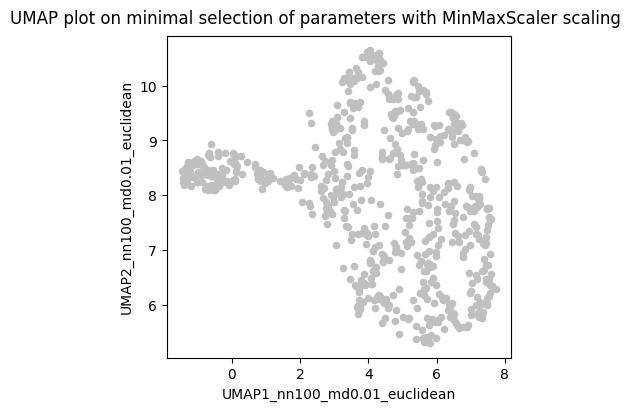

In [18]:
# General plot

title = f"UMAP plot on minimal selection of parameters with {scaling_method} scaling"
general_plot(df_minimal_scaled_UMAP, title)

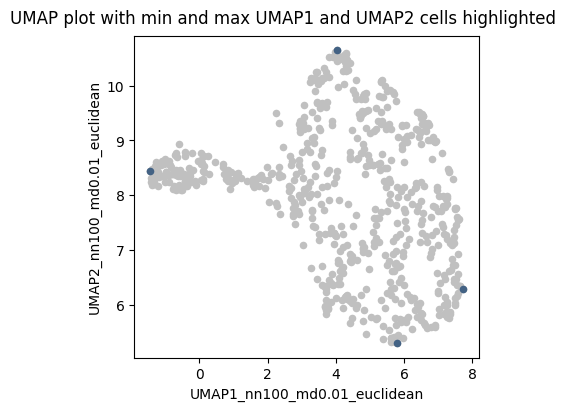

In [19]:
# Highlighting the cells with min and max UMAP1 and UMAP2

idxmin_UMAP1 = df_minimal_scaled_UMAP["UMAP1_nn100_md0.01_euclidean"].idxmin()
idxmax_UMAP1 = df_minimal_scaled_UMAP["UMAP1_nn100_md0.01_euclidean"].idxmax()

idxmax_UMAP2 = df_minimal_scaled_UMAP["UMAP2_nn100_md0.01_euclidean"].idxmax()
idxmin_UMAP2 = df_minimal_scaled_UMAP["UMAP2_nn100_md0.01_euclidean"].idxmin()

maxmin_df_UMAP = df_minimal_scaled_UMAP.loc[[idxmin_UMAP1, idxmax_UMAP1, idxmax_UMAP2, idxmin_UMAP2], :].copy()

def general_plot_example_cells(df, title): 
    fig = plt.figure(layout="constrained", figsize=(4, 4))
    fig.suptitle(title)

    x_var = [col for col in df.columns if any(k in col for k in ("UMAP1"))][0]
    y_var = [col for col in df.columns if any(k in col for k in ("UMAP2"))][0]

    sns.scatterplot(x=x_var, y=y_var, data=df, s=30, color="silver", linewidth = 0)
    sns.scatterplot(x=x_var, y=y_var, data=maxmin_df_UMAP, s=30, color="#436284", linewidth = 0)

    # plt.savefig(title + ".svg")
    plt.show()

general_plot_example_cells(df_minimal_scaled_UMAP, "UMAP plot with min and max UMAP1 and UMAP2 cells highlighted")

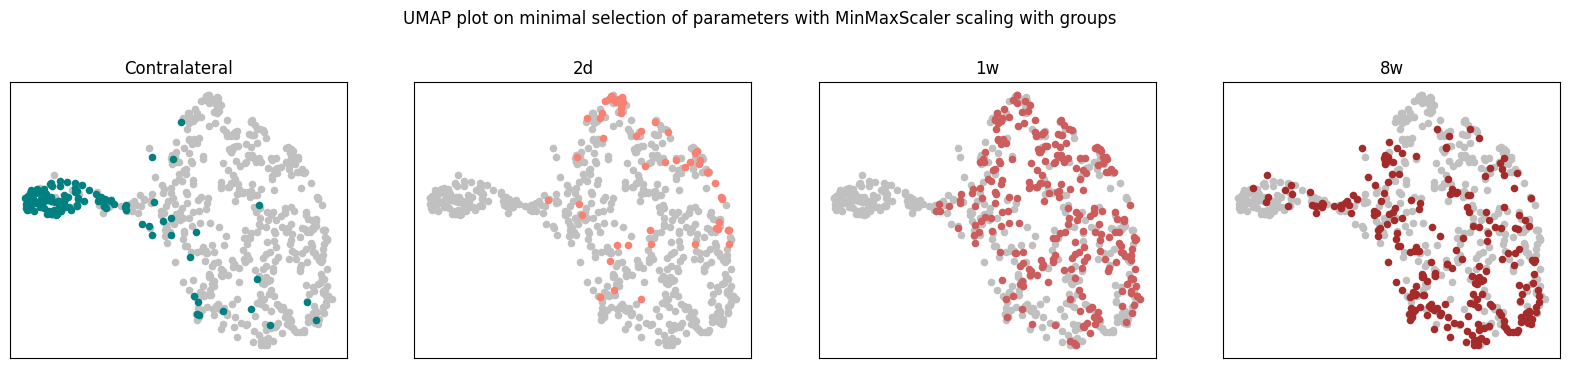

In [20]:
# Plot with time points overlaid

title = f"UMAP plot on minimal selection of parameters with {scaling_method} scaling with groups"
scatterplot_time(df_minimal_scaled_UMAP, title)

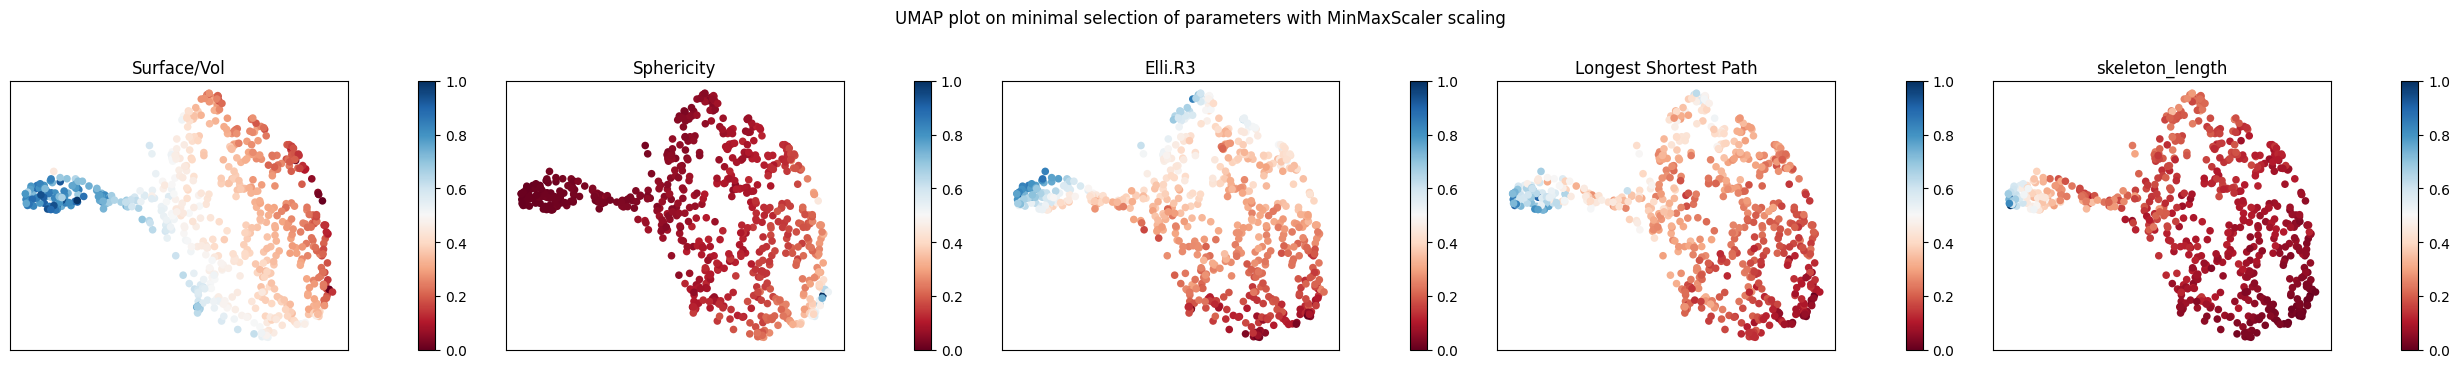

In [21]:
# Plot with variable values overlaid

title = f"UMAP plot on minimal selection of parameters with {scaling_method} scaling"
scatterplot_heat(df_minimal_scaled_UMAP, title)

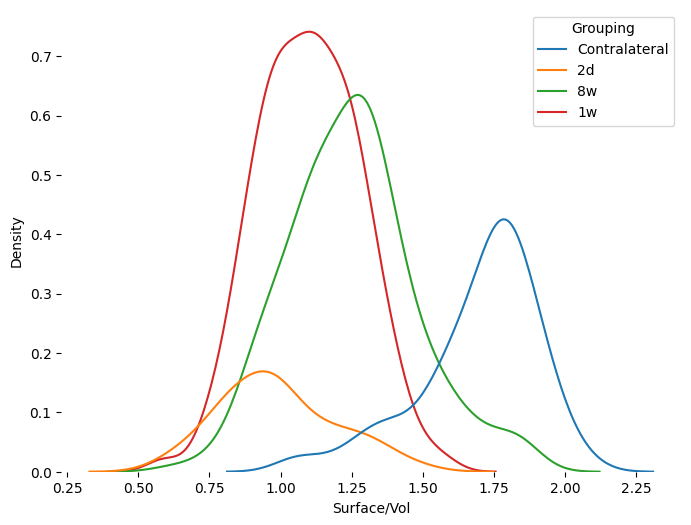

,W,pval,normal
Grouping,,,
Contralateral,0.921611,0.000002,False
2d,0.973413,0.231516,True
8w,0.986823,0.031567,False
1w,0.996405,0.828323,True


In [22]:
# Normality check for "Surface/Vol"

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.set_frame_on(False)

sns.kdeplot(data = df_Microglia, x = "Surface/Vol", hue = "Grouping",
            fill = False, ax = ax)
plt.show()

pg.normality(df_Microglia, dv = "Surface/Vol", group = "Grouping", method = 'shapiro')

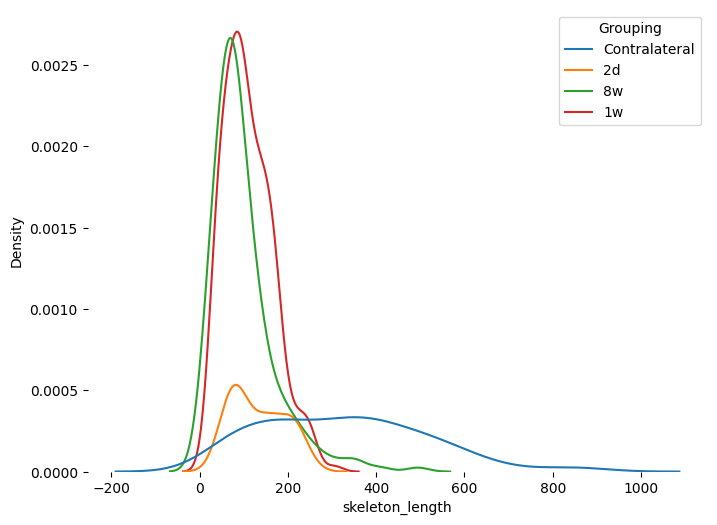

,W,pval,normal
Grouping,,,
Contralateral,0.965625,0.003161,False
2d,0.929672,0.002353,False
8w,0.825755,0.000000,False
1w,0.960890,0.000002,False


In [23]:
# Normality check for "skeleton_length"

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.set_frame_on(False)

sns.kdeplot(data = df_Microglia, x = "skeleton_length", hue = "Grouping",
            fill = False, ax = ax)
plt.show()

pg.normality(df_Microglia, dv = "skeleton_length", group = "Grouping", method = 'shapiro')

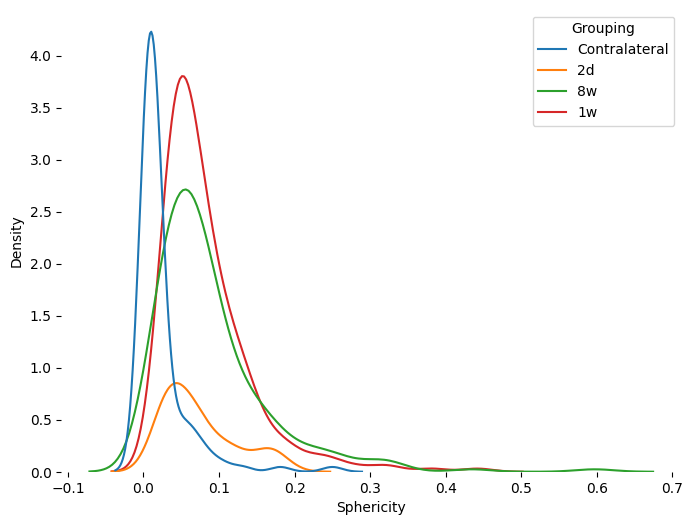

,W,pval,normal
Grouping,,,
Contralateral,0.542592,0.000000,False
2d,0.857725,0.000007,False
8w,0.774784,0.000000,False
1w,0.776123,0.000000,False


In [24]:
# Normality check for "Sphericity"

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.set_frame_on(False)

sns.kdeplot(data = df_Microglia, x = "Sphericity", hue = "Grouping",
            fill = False, ax = ax)
plt.show()

pg.normality(df_Microglia, dv = "Sphericity", group = "Grouping", method = 'shapiro')

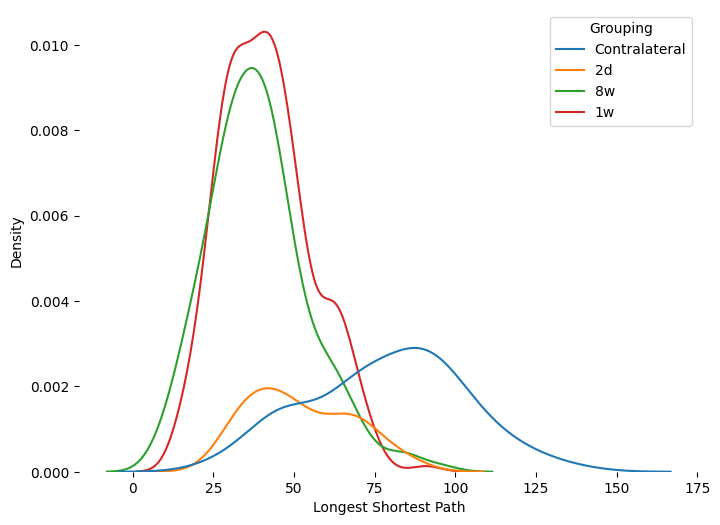

,W,pval,normal
Grouping,,,
Contralateral,0.988781,0.413457,True
2d,0.951577,0.021503,False
8w,0.970076,0.000085,False
1w,0.976579,0.000316,False


In [25]:
# Normality check for "Longest Shortest Path"

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.set_frame_on(False)

sns.kdeplot(data = df_Microglia, x = "Longest Shortest Path", hue = "Grouping",
            fill = False, ax = ax)
plt.show()

pg.normality(df_Microglia, dv = "Longest Shortest Path", group = "Grouping", method = 'shapiro')

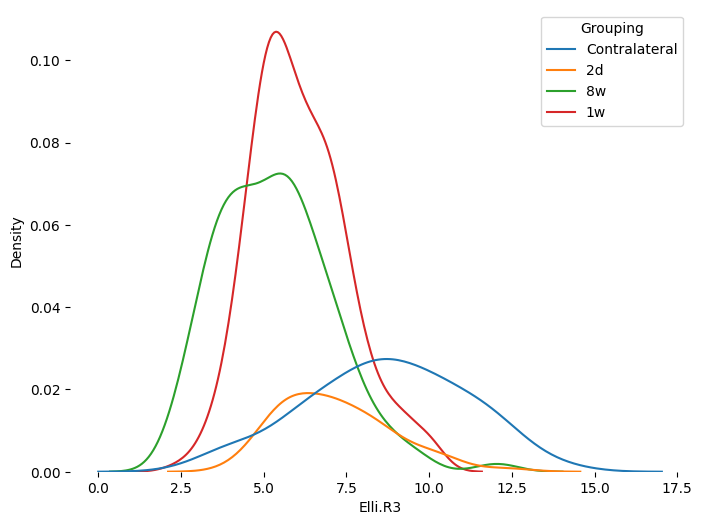

,W,pval,normal
Grouping,,,
Contralateral,0.990986,0.607316,True
2d,0.957570,0.040980,False
8w,0.968470,0.000052,False
1w,0.979908,0.001105,False


In [26]:
# Normality check for "Elli.R3"

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.set_frame_on(False)

sns.kdeplot(data = df_Microglia, x = "Elli.R3", hue = "Grouping",
            fill = False, ax = ax)
plt.show()

pg.normality(df_Microglia, dv = "Elli.R3", group = "Grouping", method = 'shapiro')

In [27]:
# Kruskal–Wallis test for "Surface/Vol"

pg.kruskal(data = df_Microglia, dv = "Surface/Vol", between = "Grouping")

,Source,ddof1,H,p-unc
Kruskal,Grouping,3,305.267230,0.000000


In [28]:
# Posthoc Dunn test for "Surface/Vol"

sp.posthoc_dunn(df_Microglia, "Surface/Vol", "Grouping", "bonferroni")

,1w,2d,8w,Contralateral
1w,1.000000,0.030766,0.000000,0.000000
2d,0.030766,1.000000,0.000000,0.000000
8w,0.000000,0.000000,1.000000,0.000000
Contralateral,0.000000,0.000000,0.000000,1.000000


In [29]:
# Kruskal–Wallis test for "skeleton_length"

pg.kruskal(data = df_Microglia, dv = "skeleton_length", between = "Grouping")

,Source,ddof1,H,p-unc
Kruskal,Grouping,3,178.714260,0.000000


In [30]:
# Posthoc Dunn test for "skeleton_length"

sp.posthoc_dunn(df_Microglia, "skeleton_length", "Grouping", "bonferroni")

,1w,2d,8w,Contralateral
1w,1.000000,0.209143,0.015593,0.000000
2d,0.209143,1.000000,0.000469,0.000000
8w,0.015593,0.000469,1.000000,0.000000
Contralateral,0.000000,0.000000,0.000000,1.000000


In [31]:
# Kruskal–Wallis test for "Sphericity"

pg.kruskal(data = df_Microglia, dv = "Sphericity", between = "Grouping")

,Source,ddof1,H,p-unc
Kruskal,Grouping,3,196.498837,0.000000


In [32]:
# Posthoc Dunn test for "Sphericity"

sp.posthoc_dunn(df_Microglia, "Sphericity", "Grouping", "bonferroni")

,1w,2d,8w,Contralateral
1w,1.000000,1.000000,1.000000,0.000000
2d,1.000000,1.000000,1.000000,0.000000
8w,1.000000,1.000000,1.000000,0.000000
Contralateral,0.000000,0.000000,0.000000,1.000000


In [33]:
# Kruskal–Wallis test for "Longest Shortest Path"

pg.kruskal(data = df_Microglia, dv = "Longest Shortest Path", between = "Grouping")

,Source,ddof1,H,p-unc
Kruskal,Grouping,3,214.634395,0.000000


In [34]:
# Posthoc Dunn test for "Longest Shortest Path"

sp.posthoc_dunn(df_Microglia, "Longest Shortest Path", "Grouping", "bonferroni")

,1w,2d,8w,Contralateral
1w,1.000000,0.000409,0.468067,0.000000
2d,0.000409,1.000000,0.000003,0.000004
8w,0.468067,0.000003,1.000000,0.000000
Contralateral,0.000000,0.000004,0.000000,1.000000


In [35]:
# Kruskal–Wallis test for "Elli.R3"

pg.kruskal(data = df_Microglia, dv = "Elli.R3", between = "Grouping")

,Source,ddof1,H,p-unc
Kruskal,Grouping,3,175.948128,0.000000


In [36]:
# Posthoc Dunn test for "Elli.R3"

sp.posthoc_dunn(df_Microglia, "Elli.R3", "Grouping", "bonferroni")

,1w,2d,8w,Contralateral
1w,1.000000,0.000950,0.000030,0.000000
2d,0.000950,1.000000,0.000000,0.025436
8w,0.000030,0.000000,1.000000,0.000000
Contralateral,0.000000,0.025436,0.000000,1.000000
